# 2.2 Hopfield Networks

## Introduction

### Noisy Input and Perception: Hopfield Networks

When you are looking out at the world through a rainstorm, your sense data are noisy with a messy distribution of water droplets partially obscuring your view at any given moment, but you are typically still able to recognize the landscape. Similarly, if you are walking through a forest on a sunny windy day the pattern of sunlight dancing on the forest floor makes your raw sense data fluctuate unpredictably, but you can still reliably recognize the path, plants, stones, etc. Sense data are often noisy, and Hopfield Networks ([Hopfield, 1982](https://doi.org/10.1073/pnas.79.8.2554)) can model how to reliably extract signal from and input of signal mixed with noise using associative nodes and thresholds.

**Installation and Setup**

In [1]:
# %%capture
# %pip install psyneulink

import numpy as np
import matplotlib.pyplot as plt
import psyneulink as pnl

## Letter Recognition

Here, we will perform pattern completion (i.e. associative memory) using a simple recurrent network. We will use a Hopfield network to recognize noisy versions of the letter "A" and "Z".

First, we will create the patterns for the letters "A" and "Z". We will use a 5x5 grid to represent each letter.

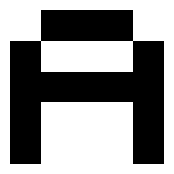

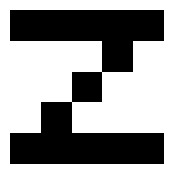

In [2]:
# Define the dimensions of the patterns
shape = (5, 5)

# Define the patterns for the letters "A"
A = np.array([
    [-1,  1,  1,  1, -1],
    [ 1, -1, -1, -1,  1],
    [ 1,  1,  1,  1,  1],
    [ 1, -1, -1, -1,  1],
    [ 1, -1, -1, -1,  1],
]).flatten()

# Define the patterns for the letters "Z"
Z = np.array([
    [ 1,  1,  1,  1,  1],
    [-1, -1, -1,  1, -1],
    [-1, -1,  1, -1, -1],
    [-1,  1, -1, -1, -1],
    [ 1,  1,  1,  1,  1],
]).flatten()


def plot_pattern(pattern, shape=shape):
    """
    Plot a `pattern` in a grid of shape `shape`.
    """
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(pattern.reshape(shape), cmap='binary')
    ax.set_axis_off()


# Plot the patterns for the letters "A" and "Z"
plot_pattern(A)
plot_pattern(Z)

Next, we'll implement how a Hopfield network can memorize patterns and recognize them when presented with noisy versions of those patterns. First, we'll set up the connections between units in our network, represented by a 25-by-25 weight matrix initialized with zeros. Each unit is connected to every other unit, and we'll manually set the diagonal of the weight matrix to zero to ensure that each unit isn't connected to itself. Each unit corresponds to a "pixel" in the input letter patterns.

To "train" the network, we supply each input pattern to the network and update the weights. Mathematically, this involves computing the outer product of each pattern (where patterns are represented using 1s and -1s) and adding it to the existing weights. This process effectively constructs a covariance matrix. The result is that when two units are coactivated in a pattern, the strength of their connection increases—an example of Hebbian learning (Hebb, 1949), which states that "neurons that fire together, wire together."

In [3]:
# Set up the "training" set to memorize.
training_set = np.array([A, Z])

# Get the shape
m, n_units = training_set.shape

# Initialize the weight matrix with zeros.
weights = np.zeros((n_units, n_units))

# Update the weights using Hebbian learning.
for pattern in training_set:
    weights += np.outer(pattern, pattern) / m

Now that the network has "memorized" the input letters, we can examine how well it recognizes novel test letters. First, let's create a function that adds noise to existing letters. The function works by replacing each pixel with a random value, with the probability of replacement determined by the noise level. 

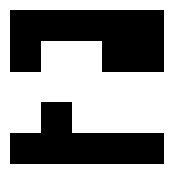

In [11]:
def add_noise(pattern, noise_level=0.2):
    """
    Add noise to a `pattern` by flipping each pixel with probability `noise_level`.
    """
    # Generate a random pattern of 1 and -1
    random_pattern = np.random.choice([-1, 1], size=pattern.shape)
    
    # Generate a noise mask based on the noise level
    noise_mask = np.random.rand(pattern.shape[0]) < noise_level
    
    # Blend the original pattern and the random pattern based on the noise mask
    noisy_pattern = pattern.copy()
    noisy_pattern[noise_mask] = random_pattern[noise_mask]
    
    return noisy_pattern

# Set a seed for reproducibility
np.random.seed(42)

# Add noise to the letter "Z"
Z_noisy = add_noise(Z)
plot_pattern(Z_noisy)

The network will attempt to associate any input pattern with one of the patterns it learned during training. For a given input pattern, we allow the network to iteratively update it over a number of steps. At each iteration, we compute the dot product between the current pattern and the learned weight matrix, which produces a new pattern. This new pattern is a transformation of the input pattern based on the learned associations encoded in the weight matrix. The network continues this process, updating the pattern at each step. After a specified number of iterations, we return the final internal state of the model: the predicted pattern. Importantly, during this stage, the weights of the network remain fixed.

In [6]:
def pattern_complete(weights, pattern, n_iter=10, soft=False):
    """
    Complete a `pattern` using the `weights` matrix for `n_iter` iterations.
    """
    # Supply pattern to weight matrix for each iteration
    patterns = []
    for _ in np.arange(n_iter):
        pattern = np.dot(pattern, weights)
        
        # Threshold resulting pattern
        if soft:
            pattern = np.tanh(pattern)
        else:
            pattern[pattern < 0] = -1
            pattern[pattern >= 0] = 1

        # Store pattern at each iteration
        patterns.append(pattern)

    return(patterns)

Finally, we'll perform pattern completion. We create a randomized test pattern and supply it to the pattern completion function. We also plot all the intermediate patterns generated during the completion process.

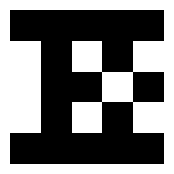

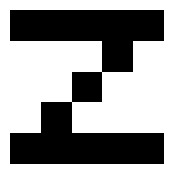

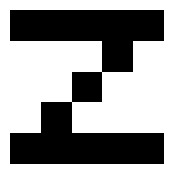

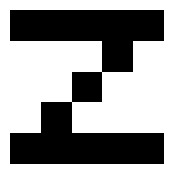

In [7]:
pattern_test = add_noise(Z, noise_level=.3)
plot_pattern(pattern_test)

n_iter = 3
patterns_pred = pattern_complete(weights, pattern_test, n_iter=n_iter)

for pattern_pred in patterns_pred:
    plot_pattern(pattern_pred)


<h4 style="background: #256ca2; color: #e9e9e9">🎯  Exercise</h4>
    

The Hopfield network here, seems to be very similar to the models discussed in the previous section on Hebbian Learning. Can you identify core differences between this model?
    


<details><summary style="background: #d6c89d; color: #e9e9e9">💡 Hint</summary>
    

Although we used recurrent networks in the PsyNeuLink implementation of the models in the previous section, the models of the previous section were ultimately feedforward networks. However, the Hopfield network is a recurrent network. 

This is a prerequisite for another fundamental difference.
    
</details>
    


<details><summary style='background: #22ae6a; color:#e9e9e9'>✅ Solution</summary>
    

The Hopfield network models an attractor network, which means that it is capable of running multiple steps and therefor dynamics. The output is not determined by a single feedforward pass, but by the dynamics of the network and probably stable states.
    
</details>
    